# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

2.0.2


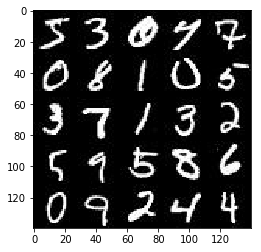

In [2]:
show_n_images = 25
import matplotlib
print(matplotlib.__version__)
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

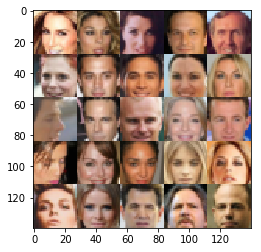

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,*(image_width,image_height,image_channels)))
    z_input = tf.placeholder(tf.float32,(None,z_dim))
    learning_rate = tf.placeholder(tf.float16,None)

    return real_input, z_input, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator',reuse= reuse):
        #14*14*64,first convolutional layer
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(alpha*conv1,conv1)
        
        #7*7*128,second convlutional layer
        conv2 = tf.layers.conv2d(conv1,128,5,strides=2,padding='same')
        conv2 = tf.layers.batch_normalization(conv2,training=True)
        conv2 = tf.maximum(alpha*conv2,conv2)
        
        #4*4*256,third convlutional layer
        conv3 = tf.layers.conv2d(conv2,256,5,strides=2,padding='valid')
        conv2 = tf.layers.batch_normalization(conv3,training=True)
        conv3 = tf.maximum(alpha*conv3,conv3)
        
        #flatten
        flat = tf.reshape(conv3,(-1,4*4*256))
        logit = tf.layers.dense(flat,1)
        output= tf.sigmoid(logit)
        
        
        
        
    return output, logit

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        #full connection layer
        x = tf.layers.dense(z,7*7*256)
        #reshape to start convolution
        x = tf.reshape(x,(-1,7,7,256))
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha*x,x)  
        
        
        #7*7*128,conv1
        conv1 = tf.layers.conv2d_transpose(x,128,5,strides=1,padding='same')
        conv1 = tf.layers.batch_normalization(conv1,training=is_train)
        conv1 = tf.maximum(alpha*conv1,conv1)  
        
        #14*14*64,conv2
        conv2 = tf.layers.conv2d_transpose(conv1,64,5,strides=2,padding='same')
        conv2 = tf.layers.batch_normalization(conv2,training=is_train)
        conv2 = tf.maximum(alpha*conv2,conv2)  
        
        # Output layer
        #28*28*N
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding='same')      
        output = tf.tanh(logits)
        
    return output
   
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim,is_train=True)
    
    d_model_real,d_logits_real = discriminator(input_real,reuse=False)
    d_model_fake,d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_fake + d_loss_real
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_var = tf.trainable_variables()
    d_var = [var for var in t_var if var.name.startswith('discriminator')]
    g_var = [var for var in t_var if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_var)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_var)
    
    return d_train_opt, g_train_opt
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #print(data_shape)
    #data_shape [sample,width,height,channel]
    width = data_shape[1]
    height = data_shape[2]
    channel = data_shape[3]
    input_real, input_z, lr = model_inputs(width,height,channel, z_dim)        
    d_loss,g_loss = model_loss(input_real,input_z,channel)      
    d_opt,g_opt = model_opt(d_loss, g_loss,lr, beta1)
    
    steps = 0
    print_every = 50
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1            
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,lr:learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps% show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channel, data_image_mode)
                    
                    

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 0/2... Discriminator Loss: 3.7778... Generator Loss: 6.3034
Epoch 0/2... Discriminator Loss: 0.7301... Generator Loss: 0.7506


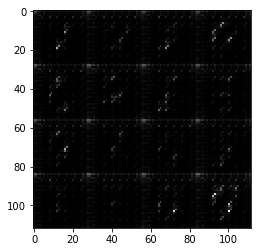

Epoch 0/2... Discriminator Loss: 4.0579... Generator Loss: 9.8684
Epoch 0/2... Discriminator Loss: 1.6619... Generator Loss: 0.2414


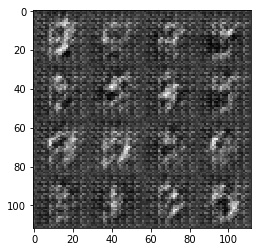

Epoch 0/2... Discriminator Loss: 1.2959... Generator Loss: 0.3495
Epoch 0/2... Discriminator Loss: 1.1109... Generator Loss: 0.5092


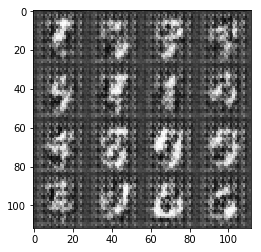

Epoch 0/2... Discriminator Loss: 1.2476... Generator Loss: 0.5069
Epoch 0/2... Discriminator Loss: 8.3545... Generator Loss: 0.0004


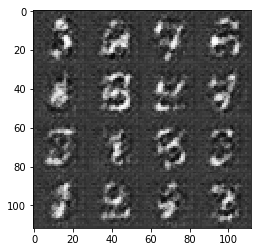

Epoch 0/2... Discriminator Loss: 0.3566... Generator Loss: 3.0372
Epoch 0/2... Discriminator Loss: 0.6485... Generator Loss: 0.9684


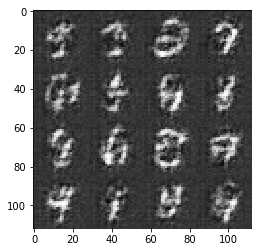

Epoch 0/2... Discriminator Loss: 0.5502... Generator Loss: 1.1642
Epoch 0/2... Discriminator Loss: 0.3683... Generator Loss: 1.8497


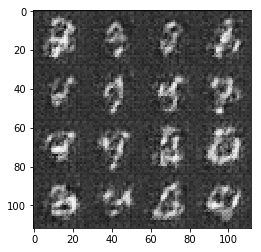

Epoch 0/2... Discriminator Loss: 0.6585... Generator Loss: 0.8924
Epoch 0/2... Discriminator Loss: 0.3043... Generator Loss: 1.6684


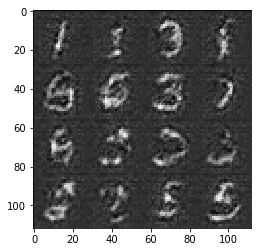

Epoch 0/2... Discriminator Loss: 0.4232... Generator Loss: 1.3135
Epoch 0/2... Discriminator Loss: 1.1843... Generator Loss: 0.4169


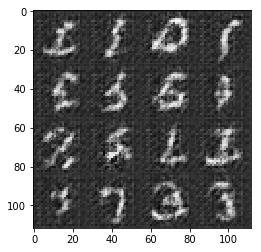

Epoch 0/2... Discriminator Loss: 0.3628... Generator Loss: 1.4705
Epoch 0/2... Discriminator Loss: 0.5404... Generator Loss: 1.0744


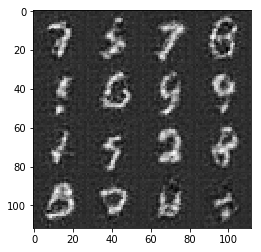

Epoch 0/2... Discriminator Loss: 0.2762... Generator Loss: 2.3013
Epoch 0/2... Discriminator Loss: 0.1207... Generator Loss: 2.9326


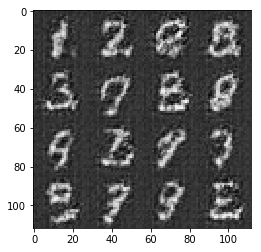

Epoch 0/2... Discriminator Loss: 1.3693... Generator Loss: 3.2048
Epoch 0/2... Discriminator Loss: 1.3508... Generator Loss: 0.3770


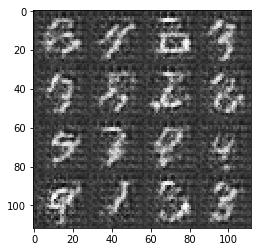

Epoch 0/2... Discriminator Loss: 0.3218... Generator Loss: 1.7979
Epoch 0/2... Discriminator Loss: 0.2918... Generator Loss: 1.6814


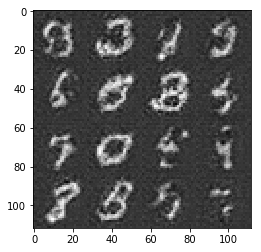

Epoch 0/2... Discriminator Loss: 0.1479... Generator Loss: 2.2604
Epoch 0/2... Discriminator Loss: 0.5505... Generator Loss: 3.6731


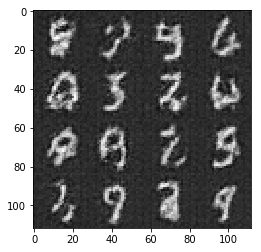

Epoch 0/2... Discriminator Loss: 0.6914... Generator Loss: 0.8597
Epoch 0/2... Discriminator Loss: 0.1736... Generator Loss: 2.6243


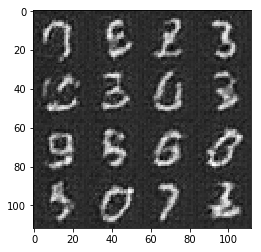

Epoch 0/2... Discriminator Loss: 0.1537... Generator Loss: 2.2341
Epoch 0/2... Discriminator Loss: 0.2854... Generator Loss: 1.8296


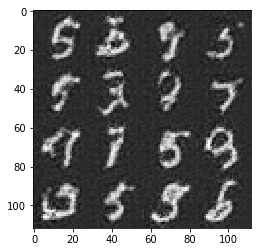

Epoch 0/2... Discriminator Loss: 0.0316... Generator Loss: 4.0994
Epoch 0/2... Discriminator Loss: 0.6572... Generator Loss: 0.8574


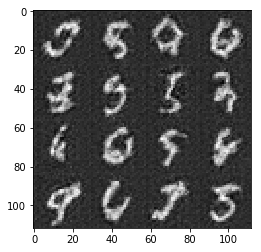

Epoch 0/2... Discriminator Loss: 0.3845... Generator Loss: 1.3513
Epoch 0/2... Discriminator Loss: 0.4747... Generator Loss: 1.2845


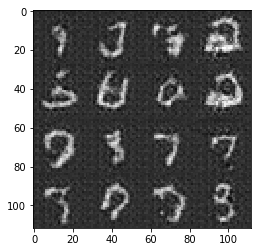

Epoch 0/2... Discriminator Loss: 0.2033... Generator Loss: 2.4929
Epoch 0/2... Discriminator Loss: 0.0722... Generator Loss: 3.9353


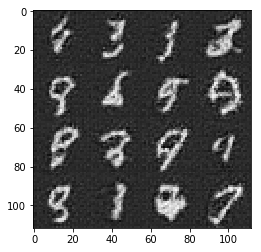

Epoch 0/2... Discriminator Loss: 0.4186... Generator Loss: 1.7767
Epoch 1/2... Discriminator Loss: 0.0670... Generator Loss: 3.2973


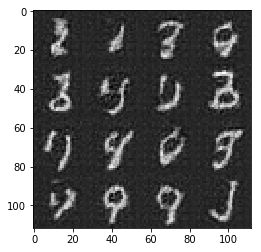

Epoch 1/2... Discriminator Loss: 0.2174... Generator Loss: 2.8582
Epoch 1/2... Discriminator Loss: 0.1469... Generator Loss: 3.1671


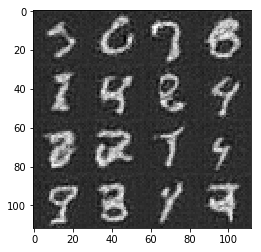

Epoch 1/2... Discriminator Loss: 0.1171... Generator Loss: 2.6591
Epoch 1/2... Discriminator Loss: 0.0573... Generator Loss: 3.4180


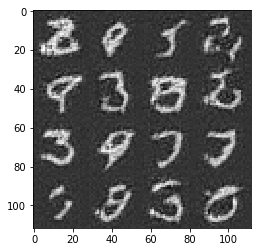

Epoch 1/2... Discriminator Loss: 1.0490... Generator Loss: 1.6925
Epoch 1/2... Discriminator Loss: 0.7707... Generator Loss: 0.9363


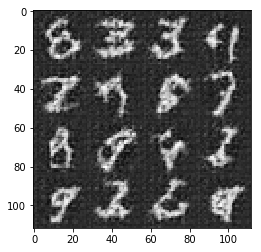

Epoch 1/2... Discriminator Loss: 0.2996... Generator Loss: 1.7564
Epoch 1/2... Discriminator Loss: 1.1507... Generator Loss: 0.5277


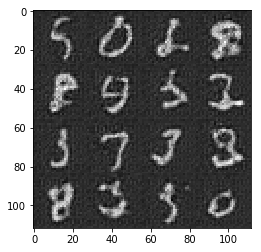

Epoch 1/2... Discriminator Loss: 0.1201... Generator Loss: 3.2068
Epoch 1/2... Discriminator Loss: 0.0617... Generator Loss: 3.8317


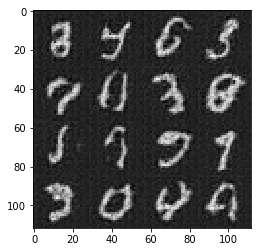

Epoch 1/2... Discriminator Loss: 0.1849... Generator Loss: 2.6153
Epoch 1/2... Discriminator Loss: 0.4134... Generator Loss: 1.7897


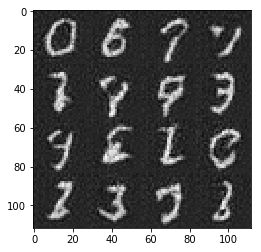

Epoch 1/2... Discriminator Loss: 0.0740... Generator Loss: 3.4450
Epoch 1/2... Discriminator Loss: 0.0920... Generator Loss: 3.0214


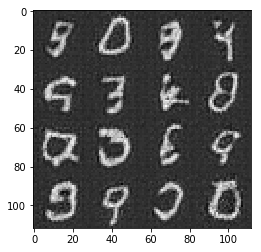

Epoch 1/2... Discriminator Loss: 0.1752... Generator Loss: 1.9926
Epoch 1/2... Discriminator Loss: 0.1088... Generator Loss: 3.4794


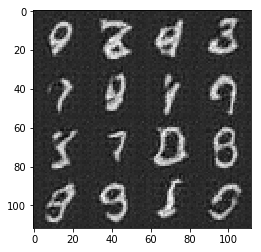

Epoch 1/2... Discriminator Loss: 0.0405... Generator Loss: 4.8875
Epoch 1/2... Discriminator Loss: 0.4515... Generator Loss: 1.4339


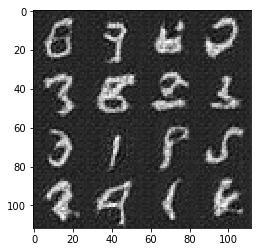

Epoch 1/2... Discriminator Loss: 1.3066... Generator Loss: 0.9659
Epoch 1/2... Discriminator Loss: 0.1694... Generator Loss: 2.4590


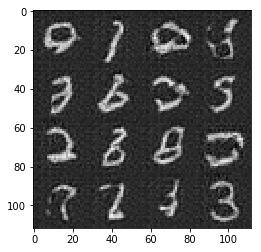

Epoch 1/2... Discriminator Loss: 0.2574... Generator Loss: 1.9978
Epoch 1/2... Discriminator Loss: 0.8432... Generator Loss: 1.4588


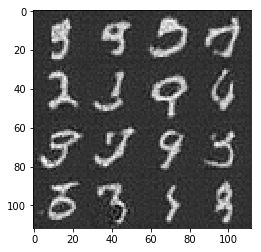

Epoch 1/2... Discriminator Loss: 0.9680... Generator Loss: 3.9047
Epoch 1/2... Discriminator Loss: 0.7266... Generator Loss: 1.3413


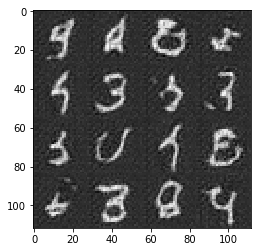

Epoch 1/2... Discriminator Loss: 0.3080... Generator Loss: 2.4231
Epoch 1/2... Discriminator Loss: 0.1112... Generator Loss: 2.9499


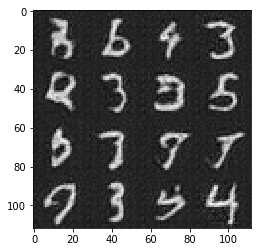

Epoch 1/2... Discriminator Loss: 0.1679... Generator Loss: 3.5303
Epoch 1/2... Discriminator Loss: 0.2896... Generator Loss: 2.6288


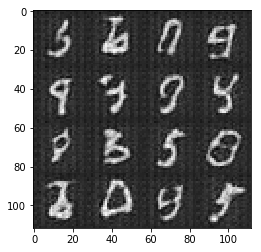

Epoch 1/2... Discriminator Loss: 0.5896... Generator Loss: 0.8959
Epoch 1/2... Discriminator Loss: 0.3794... Generator Loss: 1.6565


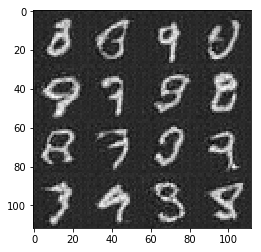

Epoch 1/2... Discriminator Loss: 0.1568... Generator Loss: 2.3622
Epoch 1/2... Discriminator Loss: 0.3277... Generator Loss: 1.7161


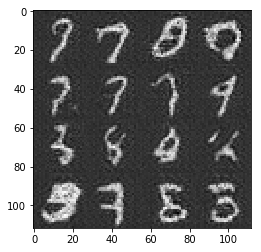

Epoch 1/2... Discriminator Loss: 0.2844... Generator Loss: 2.2722
Epoch 1/2... Discriminator Loss: 0.0830... Generator Loss: 3.4398


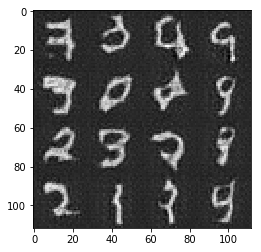

Epoch 1/2... Discriminator Loss: 1.6874... Generator Loss: 4.9341
Epoch 1/2... Discriminator Loss: 5.4658... Generator Loss: 8.8435


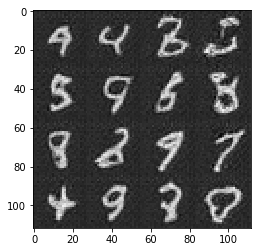

Epoch 1/2... Discriminator Loss: 0.3053... Generator Loss: 1.9927


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 0/1... Discriminator Loss: 0.5207... Generator Loss: 3.6404
Epoch 0/1... Discriminator Loss: 1.3213... Generator Loss: 0.5983


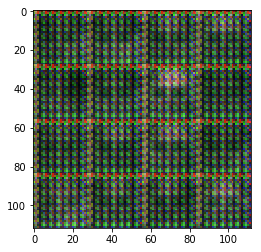

Epoch 0/1... Discriminator Loss: 0.4351... Generator Loss: 5.7069
Epoch 0/1... Discriminator Loss: 0.3038... Generator Loss: 2.9348


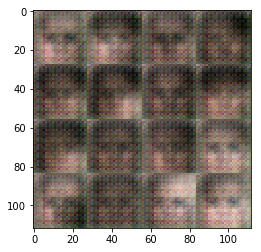

Epoch 0/1... Discriminator Loss: 0.2618... Generator Loss: 2.4318
Epoch 0/1... Discriminator Loss: 0.0269... Generator Loss: 5.4888


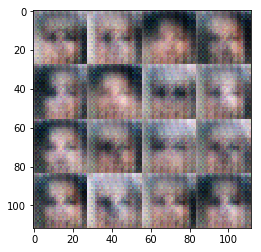

Epoch 0/1... Discriminator Loss: 0.1461... Generator Loss: 3.3930
Epoch 0/1... Discriminator Loss: 0.0204... Generator Loss: 7.2978


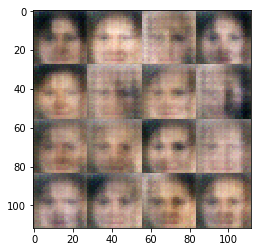

Epoch 0/1... Discriminator Loss: 2.7839... Generator Loss: 0.1509
Epoch 0/1... Discriminator Loss: 0.0486... Generator Loss: 4.6996


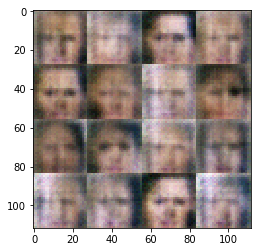

Epoch 0/1... Discriminator Loss: 0.7594... Generator Loss: 0.9528
Epoch 0/1... Discriminator Loss: 0.0224... Generator Loss: 6.9805


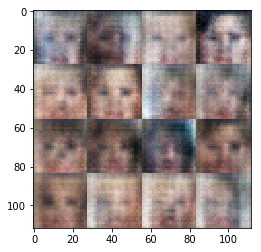

Epoch 0/1... Discriminator Loss: 0.0352... Generator Loss: 4.3203
Epoch 0/1... Discriminator Loss: 0.1761... Generator Loss: 2.0535


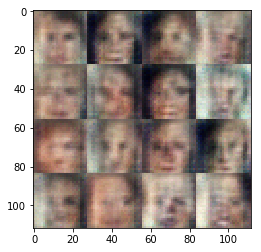

Epoch 0/1... Discriminator Loss: 0.1482... Generator Loss: 2.6176
Epoch 0/1... Discriminator Loss: 0.0965... Generator Loss: 2.8862


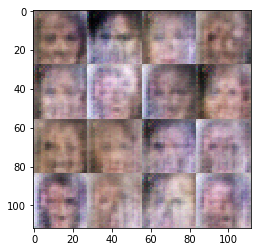

Epoch 0/1... Discriminator Loss: 0.1313... Generator Loss: 2.3865
Epoch 0/1... Discriminator Loss: 0.7493... Generator Loss: 0.8081


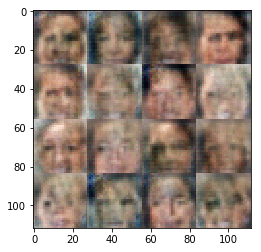

Epoch 0/1... Discriminator Loss: 0.3785... Generator Loss: 1.7287
Epoch 0/1... Discriminator Loss: 0.0600... Generator Loss: 7.3449


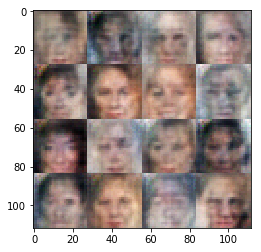

Epoch 0/1... Discriminator Loss: 0.2722... Generator Loss: 5.9618
Epoch 0/1... Discriminator Loss: 0.0840... Generator Loss: 7.2498


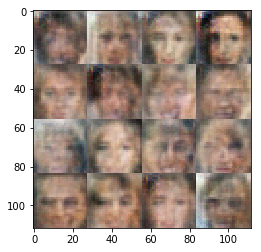

Epoch 0/1... Discriminator Loss: 0.0409... Generator Loss: 5.8820
Epoch 0/1... Discriminator Loss: 0.1487... Generator Loss: 11.9341


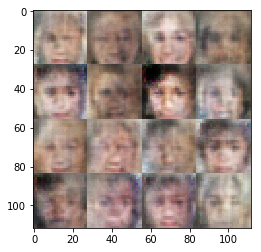

Epoch 0/1... Discriminator Loss: 0.0750... Generator Loss: 4.2858
Epoch 0/1... Discriminator Loss: 4.1644... Generator Loss: 7.3724


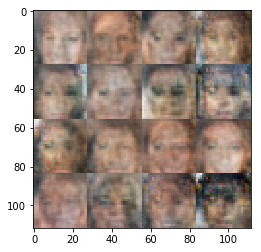

Epoch 0/1... Discriminator Loss: 0.0515... Generator Loss: 6.5535
Epoch 0/1... Discriminator Loss: 0.1670... Generator Loss: 3.3726


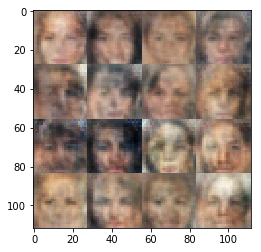

Epoch 0/1... Discriminator Loss: 0.1896... Generator Loss: 4.1821
Epoch 0/1... Discriminator Loss: 0.2154... Generator Loss: 2.2058


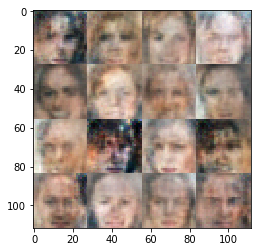

Epoch 0/1... Discriminator Loss: 0.6473... Generator Loss: 1.1181
Epoch 0/1... Discriminator Loss: 0.6696... Generator Loss: 1.4158


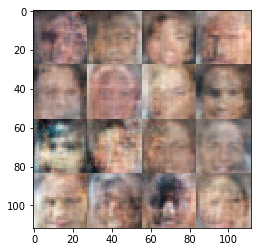

Epoch 0/1... Discriminator Loss: 0.1016... Generator Loss: 4.3924
Epoch 0/1... Discriminator Loss: 0.1083... Generator Loss: 5.9309


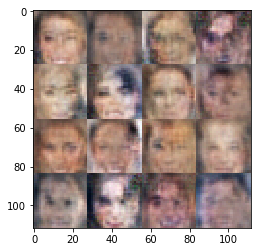

Epoch 0/1... Discriminator Loss: 0.3947... Generator Loss: 1.4775
Epoch 0/1... Discriminator Loss: 0.3188... Generator Loss: 1.5905


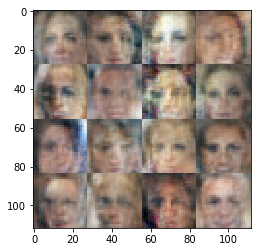

Epoch 0/1... Discriminator Loss: 0.8900... Generator Loss: 0.7956
Epoch 0/1... Discriminator Loss: 0.1853... Generator Loss: 3.9933


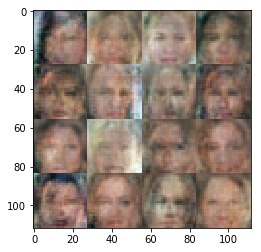

Epoch 0/1... Discriminator Loss: 1.8770... Generator Loss: 0.3675
Epoch 0/1... Discriminator Loss: 0.4198... Generator Loss: 3.9946


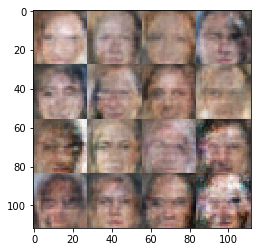

Epoch 0/1... Discriminator Loss: 0.2274... Generator Loss: 4.0279
Epoch 0/1... Discriminator Loss: 0.1423... Generator Loss: 3.3127


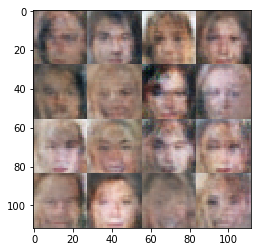

Epoch 0/1... Discriminator Loss: 1.2963... Generator Loss: 0.7637
Epoch 0/1... Discriminator Loss: 0.8665... Generator Loss: 0.8868


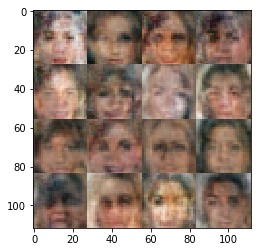

Epoch 0/1... Discriminator Loss: 0.7057... Generator Loss: 0.8668
Epoch 0/1... Discriminator Loss: 1.9820... Generator Loss: 0.3568


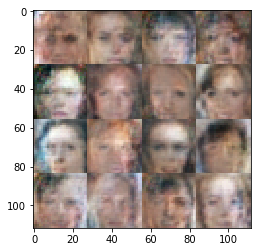

Epoch 0/1... Discriminator Loss: 1.4652... Generator Loss: 0.6937
Epoch 0/1... Discriminator Loss: 0.5288... Generator Loss: 2.8844


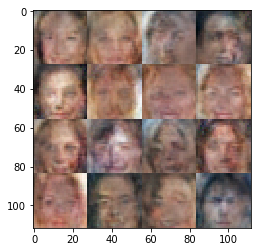

Epoch 0/1... Discriminator Loss: 0.7481... Generator Loss: 1.3619
Epoch 0/1... Discriminator Loss: 1.0150... Generator Loss: 0.7305


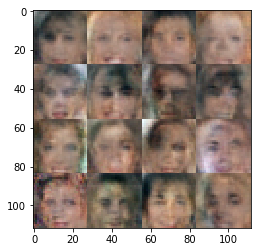

Epoch 0/1... Discriminator Loss: 0.5597... Generator Loss: 2.3311
Epoch 0/1... Discriminator Loss: 0.7283... Generator Loss: 1.4571


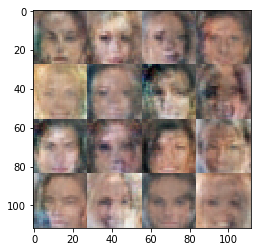

Epoch 0/1... Discriminator Loss: 0.6473... Generator Loss: 0.9893
Epoch 0/1... Discriminator Loss: 0.6125... Generator Loss: 1.0838


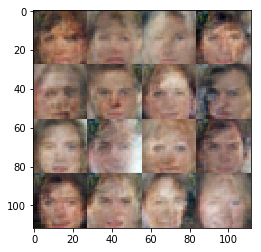

Epoch 0/1... Discriminator Loss: 1.7074... Generator Loss: 4.1239
Epoch 0/1... Discriminator Loss: 0.7724... Generator Loss: 1.8430


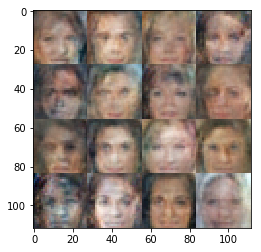

Epoch 0/1... Discriminator Loss: 0.3457... Generator Loss: 3.0993
Epoch 0/1... Discriminator Loss: 1.3362... Generator Loss: 0.3682


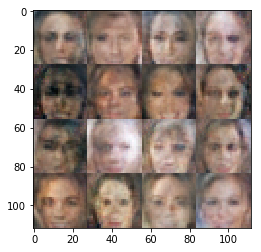

Epoch 0/1... Discriminator Loss: 1.1969... Generator Loss: 2.7556
Epoch 0/1... Discriminator Loss: 1.3190... Generator Loss: 0.5972


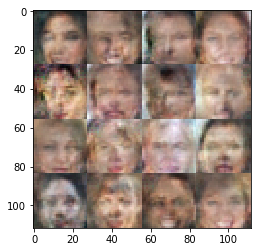

Epoch 0/1... Discriminator Loss: 0.6090... Generator Loss: 1.5730
Epoch 0/1... Discriminator Loss: 0.7625... Generator Loss: 0.8994


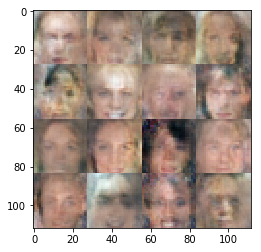

Epoch 0/1... Discriminator Loss: 0.4829... Generator Loss: 3.7591
Epoch 0/1... Discriminator Loss: 2.4719... Generator Loss: 0.1036


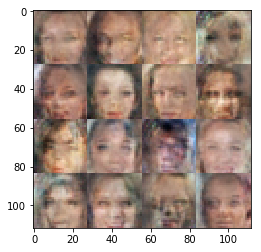

Epoch 0/1... Discriminator Loss: 0.6798... Generator Loss: 0.9093
Epoch 0/1... Discriminator Loss: 0.6377... Generator Loss: 2.9506


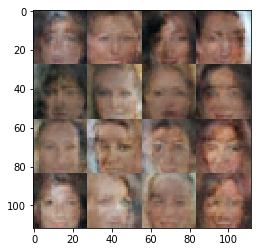

Epoch 0/1... Discriminator Loss: 0.4814... Generator Loss: 1.4340
Epoch 0/1... Discriminator Loss: 1.9672... Generator Loss: 3.9199


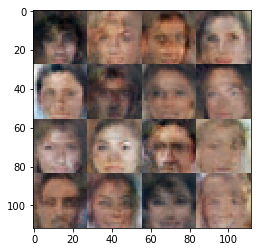

Epoch 0/1... Discriminator Loss: 0.8710... Generator Loss: 0.7106
Epoch 0/1... Discriminator Loss: 0.5730... Generator Loss: 1.0670


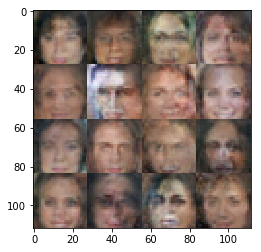

Epoch 0/1... Discriminator Loss: 0.9726... Generator Loss: 0.8773
Epoch 0/1... Discriminator Loss: 0.4404... Generator Loss: 1.6138


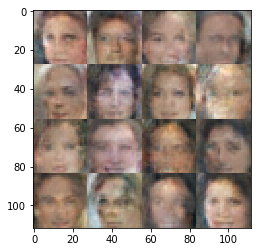

Epoch 0/1... Discriminator Loss: 0.7780... Generator Loss: 0.7861
Epoch 0/1... Discriminator Loss: 0.9214... Generator Loss: 0.7060


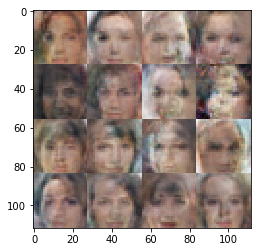

Epoch 0/1... Discriminator Loss: 0.7903... Generator Loss: 0.7119
Epoch 0/1... Discriminator Loss: 1.1496... Generator Loss: 0.4906


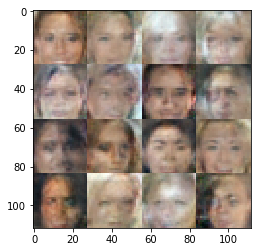

Epoch 0/1... Discriminator Loss: 0.5273... Generator Loss: 1.8077
Epoch 0/1... Discriminator Loss: 0.3768... Generator Loss: 1.9107


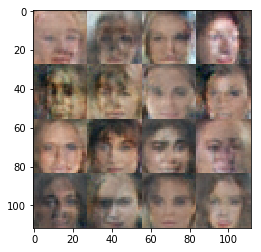

Epoch 0/1... Discriminator Loss: 1.1470... Generator Loss: 0.4439
Epoch 0/1... Discriminator Loss: 1.5424... Generator Loss: 0.2878


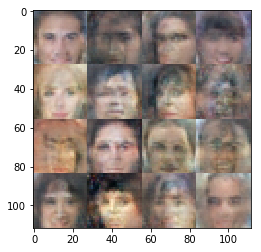

Epoch 0/1... Discriminator Loss: 0.5794... Generator Loss: 1.8184
Epoch 0/1... Discriminator Loss: 1.2432... Generator Loss: 0.6268


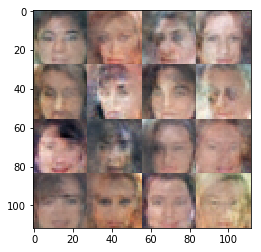

Epoch 0/1... Discriminator Loss: 0.6673... Generator Loss: 1.0859
Epoch 0/1... Discriminator Loss: 0.8085... Generator Loss: 0.6860


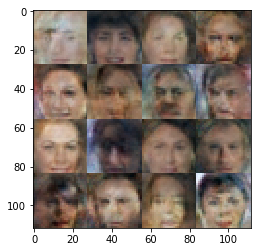

Epoch 0/1... Discriminator Loss: 0.3883... Generator Loss: 1.4329
Epoch 0/1... Discriminator Loss: 0.7714... Generator Loss: 0.9616


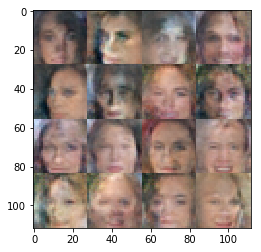

Epoch 0/1... Discriminator Loss: 1.2599... Generator Loss: 1.1297
Epoch 0/1... Discriminator Loss: 0.8761... Generator Loss: 1.2066


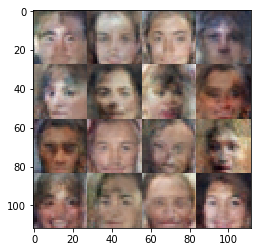

Epoch 0/1... Discriminator Loss: 0.8712... Generator Loss: 0.9275
Epoch 0/1... Discriminator Loss: 1.0504... Generator Loss: 0.7022


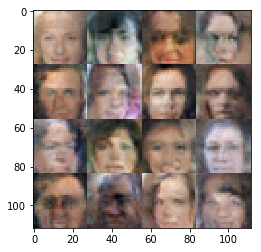

Epoch 0/1... Discriminator Loss: 0.4731... Generator Loss: 2.2888
Epoch 0/1... Discriminator Loss: 0.7234... Generator Loss: 1.1620


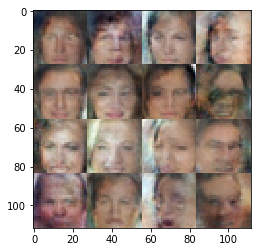

Epoch 0/1... Discriminator Loss: 2.2596... Generator Loss: 0.1403
Epoch 0/1... Discriminator Loss: 1.6585... Generator Loss: 0.2987


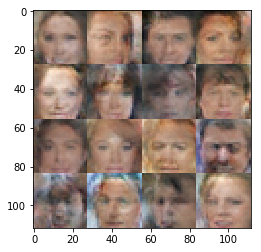

Epoch 0/1... Discriminator Loss: 0.3770... Generator Loss: 3.0127
Epoch 0/1... Discriminator Loss: 0.5051... Generator Loss: 1.2969


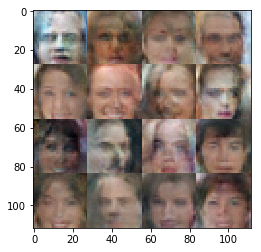

Epoch 0/1... Discriminator Loss: 1.7148... Generator Loss: 0.2646
Epoch 0/1... Discriminator Loss: 1.7076... Generator Loss: 0.3706


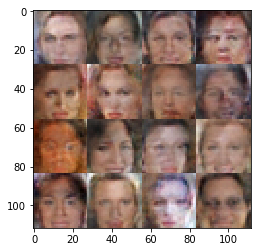

Epoch 0/1... Discriminator Loss: 1.5196... Generator Loss: 0.3243
Epoch 0/1... Discriminator Loss: 0.9257... Generator Loss: 2.8564


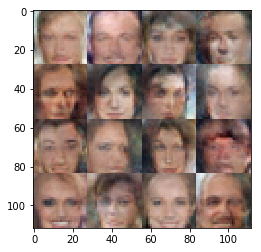

Epoch 0/1... Discriminator Loss: 0.5840... Generator Loss: 1.3261
Epoch 0/1... Discriminator Loss: 0.8011... Generator Loss: 0.7591


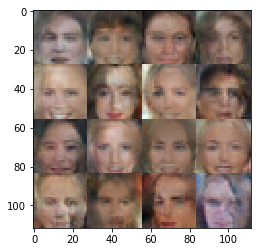

Epoch 0/1... Discriminator Loss: 1.0077... Generator Loss: 0.5862
Epoch 0/1... Discriminator Loss: 0.3843... Generator Loss: 2.0108


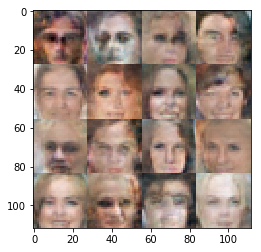

Epoch 0/1... Discriminator Loss: 0.8696... Generator Loss: 0.7493
Epoch 0/1... Discriminator Loss: 0.9122... Generator Loss: 0.7801


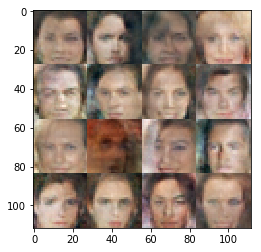

Epoch 0/1... Discriminator Loss: 0.9692... Generator Loss: 0.6636
Epoch 0/1... Discriminator Loss: 0.6533... Generator Loss: 2.9015


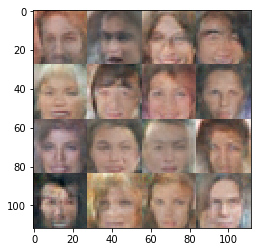

Epoch 0/1... Discriminator Loss: 1.2369... Generator Loss: 0.4166
Epoch 0/1... Discriminator Loss: 0.4720... Generator Loss: 3.5857


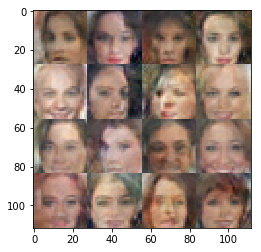

Epoch 0/1... Discriminator Loss: 2.1246... Generator Loss: 0.1627
Epoch 0/1... Discriminator Loss: 1.0575... Generator Loss: 0.5423


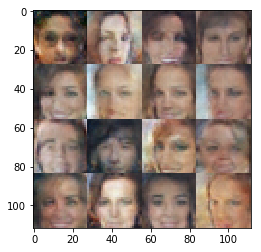

Epoch 0/1... Discriminator Loss: 1.2231... Generator Loss: 0.4853
Epoch 0/1... Discriminator Loss: 0.5810... Generator Loss: 1.2560


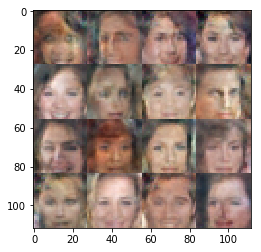

Epoch 0/1... Discriminator Loss: 1.4046... Generator Loss: 0.4413
Epoch 0/1... Discriminator Loss: 1.5516... Generator Loss: 0.3053


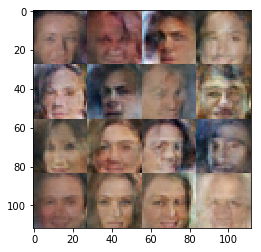

Epoch 0/1... Discriminator Loss: 0.9509... Generator Loss: 0.7486
Epoch 0/1... Discriminator Loss: 1.3482... Generator Loss: 0.4435


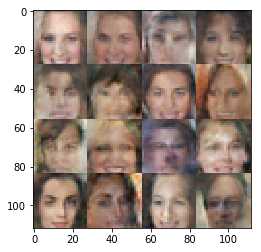

Epoch 0/1... Discriminator Loss: 0.7442... Generator Loss: 2.2533
Epoch 0/1... Discriminator Loss: 1.4305... Generator Loss: 0.3425


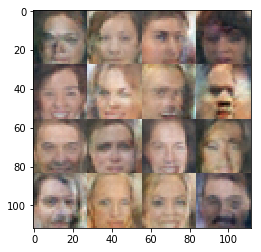

Epoch 0/1... Discriminator Loss: 0.7063... Generator Loss: 1.1146
Epoch 0/1... Discriminator Loss: 1.9929... Generator Loss: 0.1931


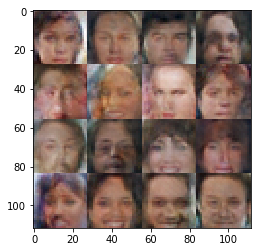

Epoch 0/1... Discriminator Loss: 0.9631... Generator Loss: 0.6037
Epoch 0/1... Discriminator Loss: 1.6679... Generator Loss: 0.4819


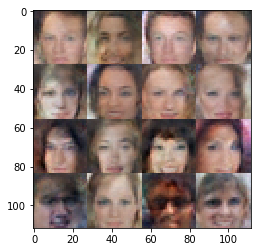

Epoch 0/1... Discriminator Loss: 1.1633... Generator Loss: 0.6527
Epoch 0/1... Discriminator Loss: 1.0086... Generator Loss: 1.5326


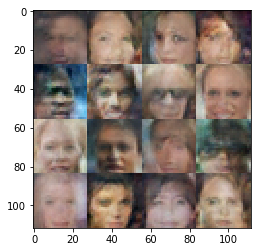

In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。